In [2]:
pip install camb

Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import math
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 15})

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__, os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /opt/conda/lib/python3.9/site-packages/camb


# Testing 'mead' against "mead2020_feedback'

There are three HMCode parameters that exist within the Halofit model used to study baryonic feedback: A_baryon, eta_baryon, and logT_AGN. logT_AGN is a variable that is unique to 'mead2020_feedback'. Therefore, it is expected that when created a best fit model that uses 'mead' for all three variables will be insufficient. In other words, 'mead2020_feedback' has to be used. However, it was found, in playing around with the 'mead2020_feedback' code, that the best fit parameters spit out by the best fit function (scipy.optimize.curve_fit()) do not tell what the A and eta best fit values are. Instead, it spits out the default values ([3.13, 0.603]). It does, however, provide the logT_AGN best fit value. To the best of my abilities, I was not able to resolve this issue. It is currently believed that there is a bug in either camb or the HMCode that is resulting in this. Despite not telling me what the best fit values are, it does not appear that the curve produced is affected. In other words, it does not seem that the best fit curve is using the default values that it is spitting out. It is instead using the true best fit values and creating a curve based on these "hidden" values, producing a desired best fit curve. The issue is that the code fails to tell me what the true values of these "hidden" parameters are, rather than telling me what the defaults are. 

On the other hand, if 'mead' was used in the best fit function then the A and eta best fit values are spit out appropriately, but the logT_AGN value is not (logT_AGN defaults ([7.8])). However, this is an expected result considering 'mead' does not support the logT_AGN parameter.

In order to determine the effects of this possible bug on the best fit model I seek to create, I need to better understand what the HMCode is doing, what the best fit function is spitting out, and whether or not any information is being lost when using 'mead' versus 'mead2020_feedback' to find the best fit values. Because the resulting best fit curve does not appear to be affected by this bug, I merely need to find a work-around solution that can be used in the meantime to determine what the "hidden" A and eta values are.

The following tests allowed me to come to such 'work-around solution'. In these tests I use fake observation data that uses Plank2018 cosmology but sets omch2$\rightarrow$omch2*1.03. Therefore the best fit curves will attempt to match this cosmology using only baryonic feedback:

## Test 1 - Testing one variable at a time:

I will create a total of 6 functions: An A and eta function that uses 'mead2020_feedback' (2), an A and eta function that uses 'mead' (2), and two (2) logT_AGN function that both 'mead2020_feedback' but use either the 'mead' A and eta best fit values or the 'mead2020_feedback' A and eta best fit values ('mead2020_feedback' will always be used for logT_AGN since logT_AGN only exists in the 'mead2020_feedback' halofit version). I will find the best fit values of each of these functions separately, one at a time, and then plug them back into a compounding function, which will contain only best fit values, and plot their subsequent curves. In doing so I will attempt to determine whether or not the values obtained for A and eta using 'mead' are the same as those obtained in 'mead2020_feedback' (i.e. is any information lost?). 

In [4]:
pars_test = camb.set_params(H0=67.5, 
                            ombh2=0.022, 
                            omch2=0.120*1.03, 
                            redshifts=[0], 
                            kmax=10, 
                            As=2e-9, 
                            ns=0.96, 
                            halofit_version='mead2020_feedback', 
                            HMCode_A_baryon = 0, 
                            HMCode_eta_baryon = 0, 
                            HMCode_logT_AGN = -10)
                            # zero the HMCode to get a universe without baryonic feedback
results_test = camb.get_transfer_functions(pars_test)
kh_test, _, pk_test = results_test.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

kh_data = kh_test
pk_data = pk_test[0]

In [5]:
# Create A model using 'mead2020_feedback' #

def A_model_feedback(xdata, A_baryon):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

A_guess = np.array([3.13])
popt_A_feedback, pcov_A_feedback = scipy.optimize.curve_fit(A_model_feedback, kh_data, pk_data, A_guess)

popt_A_feedback

/opt/conda/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([3.13])

In [6]:
# Create A model using 'mead' #

def A_model_mead(xdata, A_baryon):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = A_baryon)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

A_guess = np.array([3.13])
popt_A_mead, pcov_A_mead = scipy.optimize.curve_fit(A_model_mead, kh_data, pk_data, A_guess)

popt_A_mead

array([3.13])

In [7]:
# Create eta model using 'mead2020_feedback' #

def eta_model_feedback(xdata, eta_baryon):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = popt_A_feedback, 
                           HMCode_eta_baryon = eta_baryon)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

eta_guess = np.array([0.603])
popt_eta_feedback, pcov_eta_feedback = scipy.optimize.curve_fit(eta_model_feedback, kh_data, pk_data, eta_guess)

popt_eta_feedback

array([0.603])

In [9]:
# Create eta model using 'mead' #

def eta_model_mead(xdata, eta_baryon):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = popt_A_mead,
                           HMCode_eta_baryon = eta_baryon)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

eta_guess = np.array([3.13])
popt_eta_mead, pcov_eta_mead = scipy.optimize.curve_fit(eta_model_mead, kh_data, pk_data, eta_guess)

popt_eta_mead

array([0.48879041])

In [13]:
# Create logT_AGN model using 'mead2020_feedback', but using the 'mead' A and eta best fit values #

def logT_AGN_mead(xdata, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = popt_A_mead,
                           HMCode_eta_baryon = popt_eta_mead,
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

AGN_guess = np.array([7.8])
popt_AGN_mead, pcov_AGN_mead = scipy.optimize.curve_fit(logT_AGN_mead, kh_data, pk_data, AGN_guess)

popt_AGN_mead

array([7.68979455])

In [14]:
# Create logT_AGN model using 'mead2020_feedback', but using the 'meead2020_feedback' A and eta best fit values #

def logT_AGN_feedback(xdata, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = popt_A_feedback,
                           HMCode_eta_baryon = popt_eta_feedback,
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

AGN_guess = np.array([7.8])
popt_AGN_feedback, pcov_AGN_feedback = scipy.optimize.curve_fit(logT_AGN_feedback, kh_data, pk_data, AGN_guess)

popt_AGN_feedback

array([7.68979455])

In [15]:
# Combine the best fit values into separate arrays #
best_fit_params_feedback = np.array([popt_A_feedback[0], popt_eta_feedback[0], popt_AGN_feedback[0]])
best_fit_params_mead = np.array([popt_A_mead[0], popt_eta_mead[0], popt_AGN_mead[0]])

print('mead2020_feedback:\nA_baryon = {0:.3f} \neta_baryon = {1:.3f}\nlogT_AGN = {2:.3f}\n'.format(*best_fit_params_feedback))
print('mead:\nA_baryon = {0:.3f} \neta_baryon = {1:.3f}\nlogT_AGN = {2:.3f}'.format(*best_fit_params_mead)) 

mead2020_feedback:
A_baryon = 3.130 
eta_baryon = 0.603
logT_AGN = 7.690

mead:
A_baryon = 3.130 
eta_baryon = 0.489
logT_AGN = 7.690


In [16]:
# Compounding function that takes in all the calculated best fit values #

def baryon_feedback_model(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

In [20]:
# Create the two best fit MPS curves #

pk_mead = baryon_feedback_model(kh_data, *best_fit_params_mead)
pk_feedback = baryon_feedback_model(kh_data, *best_fit_params_feedback)

Equal?: True


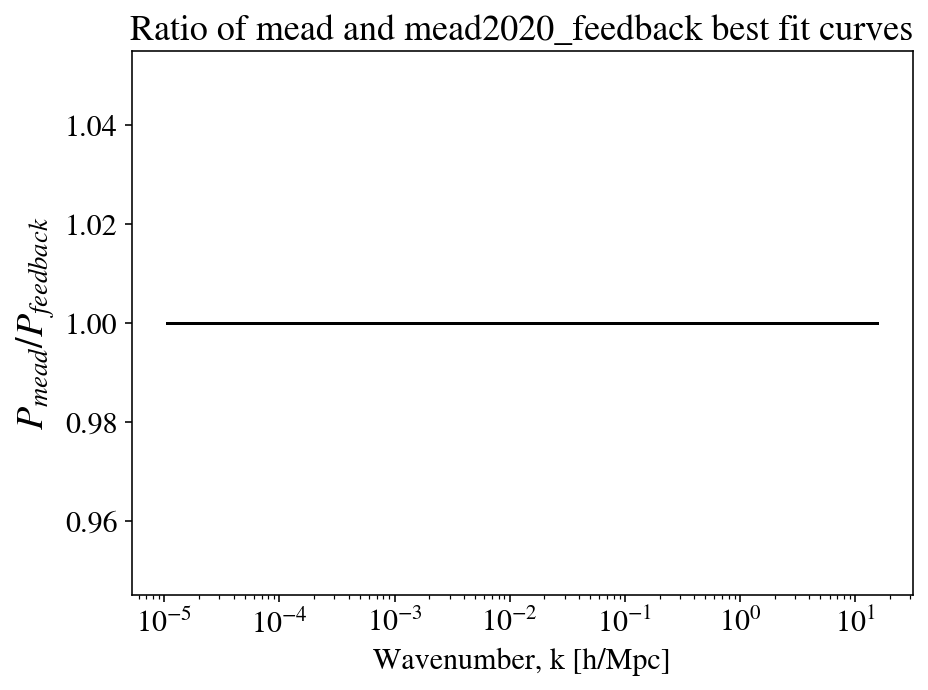

In [31]:
# Are the two curves the same? #

print('Equal?:', np.array_equal(pk_mead, pk_feedback))

plt.figure(figsize=(7,5))
plt.semilogx(kh_data, pk_mead/pk_feedback, 'k-')
plt.title('Ratio of mead and mead2020_feedback best fit curves')
plt.ylabel('$P_{mead}/P_{feedback}$', fontsize=19)
plt.xlabel('Wavenumber, k [h/Mpc]')
plt.show()

$\textbf{Solving for one variable at a time -- Results:}$

I attempted to answer one main question: does using 'mead' on A/eta_baryon versus 'mead2020_feedback' (each time using mead2020_feedback for logT_AGN) change the final results? In otherwords, is the resulting best fit curve changed and, therefore, are the resulting best fit parameters dependent upon the choice of 'mead' or 'mead2020_feedback'? 

Two best fit parameter arrays were obtained, one in which A and eta were determined using 'mead' and another where they were determined by 'mead2020_feedback'. Their respective best fit MPS curves were plotted against each other using a ratio plot. Furthermore, the two curves analyzed analytically using np.array_equal(). Both the ratio plots and the np.array_equal() function showed that the two best fit curves were identical.

Essential conclusion: When using 'mead' to find the A/eta best fit parameters the result is the same as that using 'mead2020_feedback', with one key distinction: using 'mead2020_feedback' to find A and eta will fail to tell you what the calculated best fit values are, though the code seems to internalize the best fit values, and will only return the initial guesses given in the curve fitting process. However, 'mead' does tell you what the best fit values are. It appears that no information is lost in the process of using 'mead' over 'mead2020_feedback', with the exception that you cannot print out the  best fit values when using 'mead2020_feedback'. Therefore, it can be assumed that using 'mead' rather than 'mead2020_feedback, in this debugging test, is okay and nothing changes/no information is lost.

Next test: try the same thing except merge the A and eta models to create a 2-variable function....

## Test 2 - Testing two variables at a time: 
### Comparing 2-var A/eta model (A_eta_model using either 'mead' or 'mead2020_feeback', logT_AGN_model using 'mead2020_feedback' (similar to Test 1 logT_AGN functions))
Here, a total of 4 functions will be created. The main difference will be in the A and eta functions, in which these two variables will be merged, but one will use 'mead' and the other will use 'mead2020_feedback'. I will now merge the two functions into one. The logT_AGN functions will be essentially identical to those used in Test 1. I am once again trying to determine if any information is lost when using 'mead' versus 'mead2020_feedback'.

In [33]:
# Create A/eta model using 'mead' #

def A_eta_model_mead(xdata, A_baryon, eta_baryon):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

guesses_A_eta = np.array([3.13, 0.603])
popt_A_eta_mead, pcov_A_eta_mead = scipy.optimize.curve_fit(A_eta_model_mead, kh_data, pk_data, guesses_A_eta) 

/opt/conda/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [36]:
# Create A/eta model using 'mead2020_feedback' #

def A_eta_model_feedback(xdata, A_baryon, eta_baryon):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

guesses_A_eta = np.array([3.13, 0.603])
popt_A_eta_feedback, pcov_A_eta_feedback = scipy.optimize.curve_fit(A_eta_model_feedback, kh_data, pk_data, guesses_A_eta) 

In [37]:
# Create logT_AGN model using 'mead2020_feedback', but using the 'mead' A and eta best fit values #

def logT_AGN_mead(xdata, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = popt_A_eta_mead[0],
                           HMCode_eta_baryon = popt_A_eta_mead[1],
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

AGN_guess = np.array([7.8])
popt_AGN_mead, pcov_AGN_mead = scipy.optimize.curve_fit(logT_AGN_mead, kh_data, pk_data, AGN_guess)

In [38]:
# Create logT_AGN model using 'mead2020_feedback', but using the 'mead2020_feedback' A and eta best fit values #

def logT_AGN_feedback(xdata, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = popt_A_eta_feedback[0],
                           HMCode_eta_baryon = popt_A_eta_feedback[1],
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

AGN_guess = np.array([7.8])
popt_AGN_feedback, pcov_AGN_feedback = scipy.optimize.curve_fit(logT_AGN_feedback, kh_data, pk_data, AGN_guess)

In [43]:
# Combine the best fit values into separate arrays #

best_fit_params_mead = np.array([*popt_A_eta_mead, popt_AGN_mead[0]])
best_fit_params_feeback = np.array([*popt_A_eta_feedback, popt_AGN_feedback[0]])

print('mead:', best_fit_params_mead, '\nmead2020_feedback:', best_fit_params_feedback)

mead: [3.15435792 0.58716049 7.68979455] 
mead2020_feedback: [3.13       0.603      7.68979455]


In [45]:
# Compounding function that takes in all the calculated best fit values #

def baryon_feedback_model(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

In [46]:
# Create the two best fit MPS curves #

pk_mead = baryon_feedback_model(kh_data, *best_fit_params_mead)
pk_feedback = baryon_feedback_model(kh_data, *best_fit_params_feedback)

Equal?: True


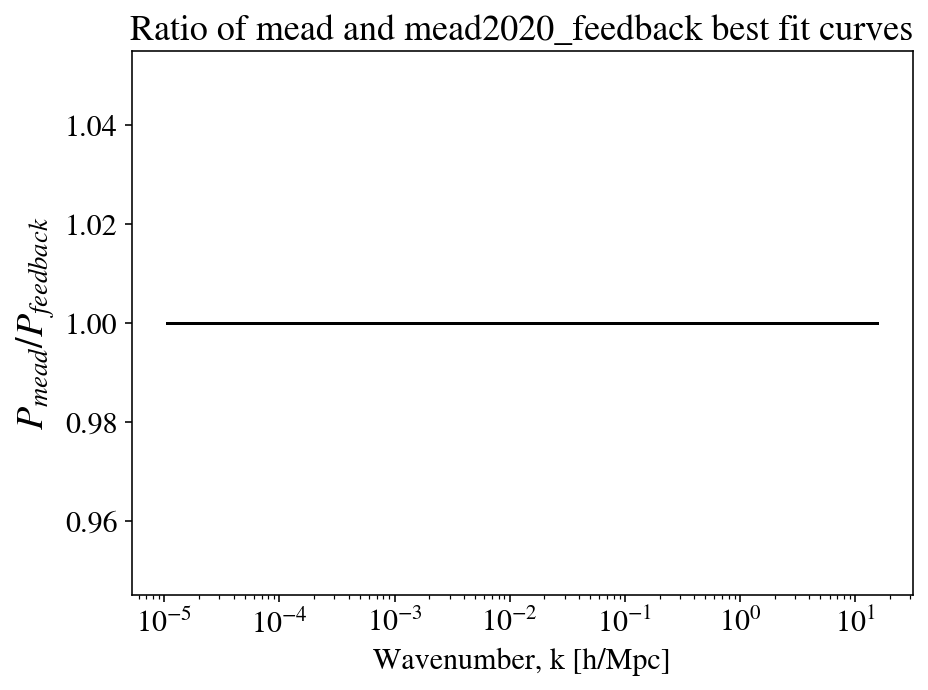

In [47]:
# Are the two curves the same? #

print('Equal?:', np.array_equal(pk_mead, pk_feedback))

plt.figure(figsize=(7,5))
plt.semilogx(kh_data, pk_mead/pk_feedback, 'k-')
plt.title('Ratio of mead and mead2020_feedback best fit curves')
plt.ylabel('$P_{mead}/P_{feedback}$', fontsize=19)
plt.xlabel('Wavenumber, k [h/Mpc]')
plt.show()

$\textbf{Merging A/eta into one model -- Results:}$

I wished to merge A and eta into a single model as this will increase the effacacy of the best fit results, but I needed to first confirm that, like was seen in previous test's results, no information is lost in using 'mead' over 'mead2020_feedback'. As is seen by both the ratio plot as well as the np.array_equal() output, once again no information is lost. I will now work to create a 3-varible function that builds on these results.

## Test 3 - Testing 3 variables at one time:

Here, I will create a total of 2 functions that merge all three parameters: one (1) where 'mead' is exclusively used, including for the logT_AGN param, and one (1) where 'mead2020_feedback' is exclusively used. Since logT_AGN is a variable only introduced in 'mead2020_feedback', I do not expect these two functions to be the same. In other words, I expect their resulting best fit MPS curves will not be equal to one another. However, once the best fit values are obtained using both 'mead' and 'mead2020_functions', I will create a third array. This array will be a "pieced together" array, containing the A and eta best fit values from the 'mead' best fit function and the logT_AGN value from the 'mead2020_feedback' best fit function. I will then run these "pieced together best fit values" through the baryon_feedback_model to produce a curve and compare this "pieced together" curve with that of the 'mead2020_feedback' curve. The results of this will tell me is the "pieced together" best fit values are equivalent to the 'mead2020_feedback values', thus providing me with the 'work-around' solution that I am hoping for.

In [48]:
# Creating 'mead' model #

def baryon_model_mead(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

guesses = np.array([3.13, 0.603, 7.8])
popt_mead, pcov_mead = scipy.optimize.curve_fit(baryon_model_mead, kh_data, pk_data, guesses) 

/opt/conda/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [49]:
# Creating 'mead2020_feedback' model #

def baryon_model_feedback(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

guesses = np.array([3.13, 0.603, 7.8])
popt_feedback, pcov_feedback = scipy.optimize.curve_fit(baryon_model_feedback, kh_data, pk_data, guesses)

In [50]:
# Best fit parameters #

best_fit_params_mead = popt_mead
best_fit_params_feedback = popt_feedback

print('mead:', best_fit_params_mead, '\nmead2020_feedback:', best_fit_params_feedback)

mead: [3.08755532 0.59485738 7.8       ] 
mead2020_feedback: [3.13       0.603      7.68979458]


In [51]:
# Creating the "pieced together" best fit parameters #

pieced_together_best_fit_params = np.array([best_fit_params_mead[0], best_fit_params_mead[1], best_fit_params_feedback[2]])

print('Pieced together best fit params:', pieced_together_best_fit_params)

Pieced together best fit params: [3.08755532 0.59485738 7.68979458]


In [54]:
# Creating best fit MPS curves #

pk_pieced_together = baryon_model_feedback(kh_data, *pieced_together_best_fit_params)
pk_feedback = baryon_model_feedback(kh_data, *best_fit_params_feedback)

Equal?: True


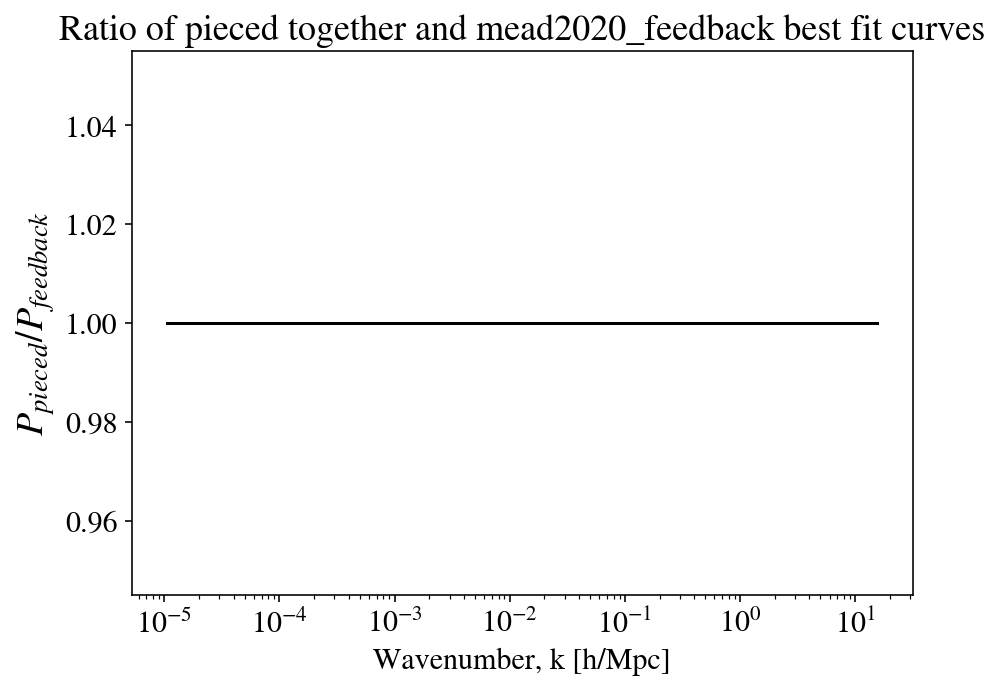

In [56]:
# Are the two curves the same? #

print('Equal?:', np.array_equal(pk_pieced_together, pk_feedback))

plt.figure(figsize=(7,5))
plt.semilogx(kh_data, pk_pieced_together/pk_feedback, 'k-')
plt.title('Ratio of pieced together and mead2020_feedback best fit curves')
plt.ylabel('$P_{pieced}/P_{feedback}$', fontsize=19)
plt.xlabel('Wavenumber, k [h/Mpc]')
plt.show()

In [57]:
# Reference function: Planck2018 comsology, HMCode=0 for no baryonic feedback #

pars_planck_2018 = camb.set_params(H0=67.4, ombh2=0.0224, omch2=0.120,
                                  redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                                  halofit_version='mead2020_feedback',
                                  HMCode_A_baryon=0, HMCode_eta_baryon=0, HMCode_logT_AGN=-10)
results_planck_2018 = camb.get_transfer_functions(pars_planck_2018)
kh_planck2018, _, pk_planck2018 = results_planck_2018.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

<Figure size 432x288 with 0 Axes>

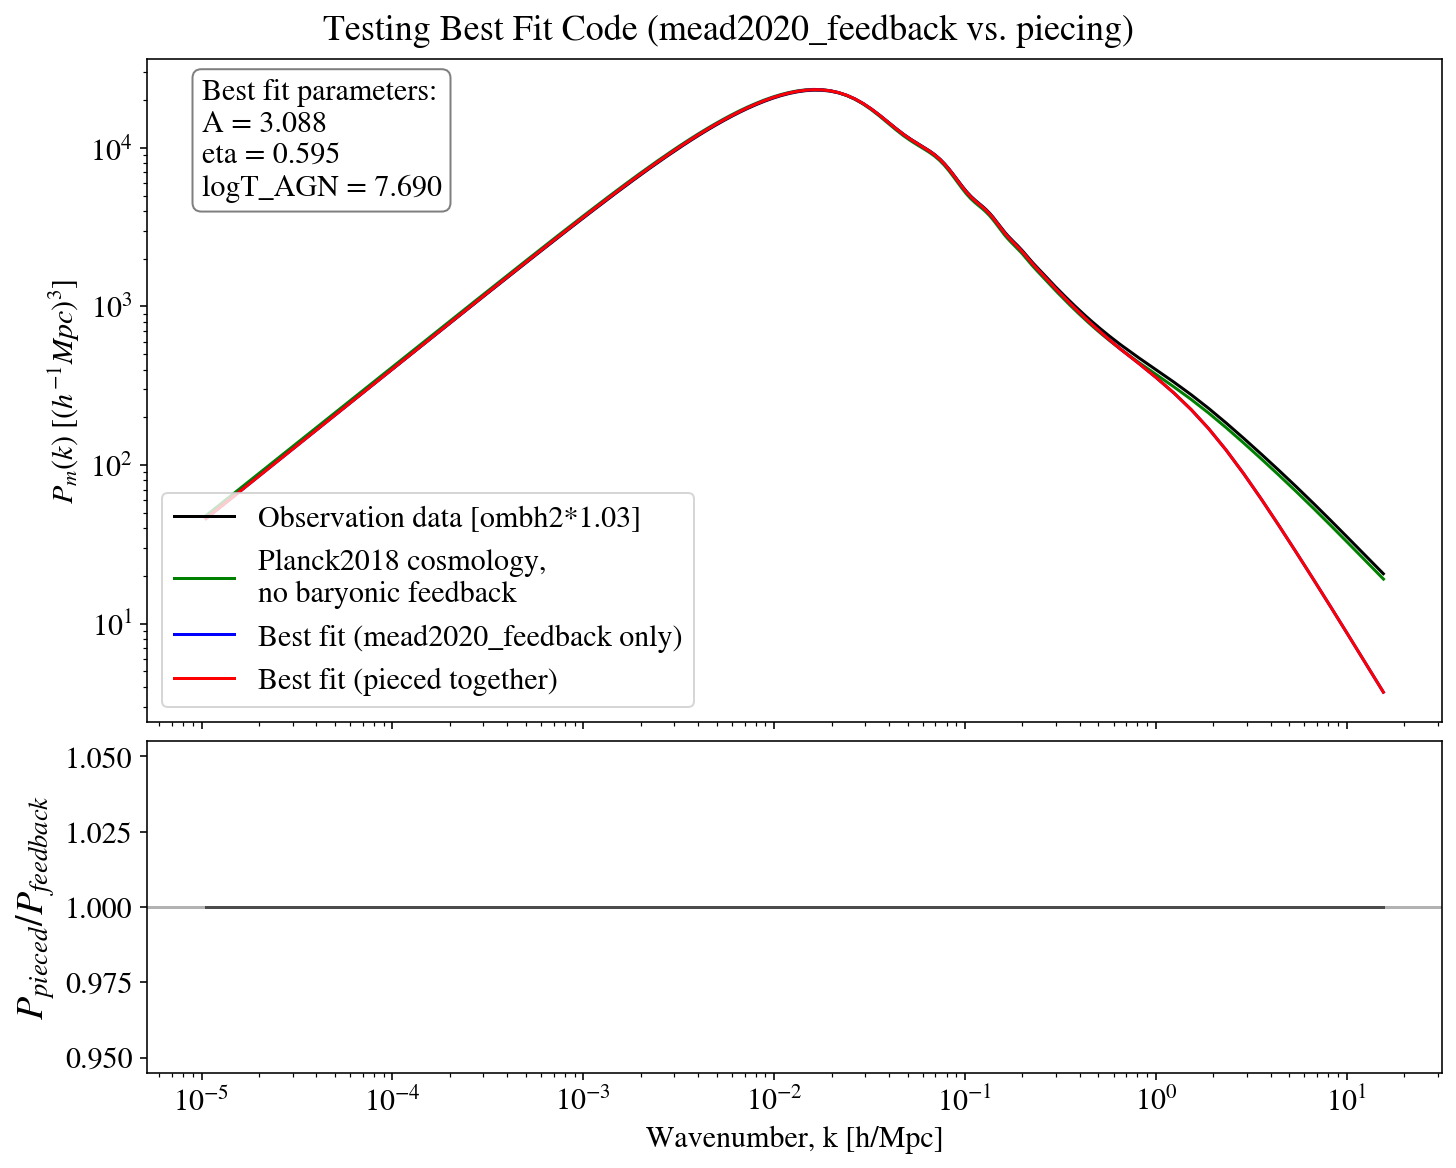

In [59]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, 
                               figsize=(10,8), 
                               constrained_layout=True, 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[3, 1.5]})
fig.suptitle('Testing Best Fit Code (mead2020_feedback vs. piecing)')

ax0.loglog(kh_data, pk_data, 'k-', label='Observation data [ombh2*1.03]')
ax0.loglog(kh_planck2018, pk_planck2018[0], 'g-', label='Planck2018 cosmology,\nno baryonic feedback')
ax0.loglog(kh_data, pk_feedback, 'b-', label='Best fit (mead2020_feedback only)')
ax0.loglog(kh_data, pieced_together_best_fit, 'r-', label='Best fit (pieced together)')
ax0.set_ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
ax0.legend(loc='lower left')
props = dict(boxstyle='round', facecolor='white', alpha = 0.5)
ax0.text(0.00001, 5000, 'Best fit parameters:\nA = {0:.3f}\neta = {1:.3f}\nlogT_AGN = {2:.3f}'.format(*pieced_together_best_fit_params), bbox=props)

ax1.semilogx(kh_data, pk_pieced_together/pk_feedback, 'k-')
ax1.axhline(1, color='grey', alpha=0.6)
ax1.set_ylabel('$P_{pieced}/P_{feedback}$', fontsize=19)
ax1.set_xlabel('Wavenumber, k [h/Mpc]')
plt.show()

$\textbf{3-var model results:}$

The desired results were obtained! The piecing method works as a 'work-around' solution to the bug in the code. Given the results, it is assumed that 'mead2020_feedback' calls back upon the 'mead' version when working with A and eta parameters. This suggests to me that 'mead2020_feedback' is merely an update to the 'mead' code, one in which logT_AGN was added but A and eta remained unchanged. This means that we can obtain and print out the best fit values using this piecing method, while still relying on the plotted and computational results of 'mead2020_feedback'. All of this can be done without the loss of information in the process.